In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
import torch as tr

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

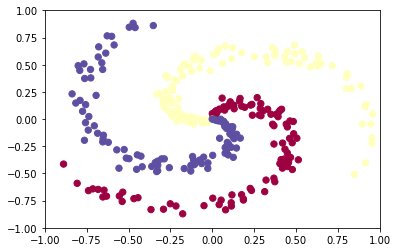

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

In [ ]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print ("Iteration {0}, loss {1}".format(i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

In [ ]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ("training accuracy: {0}".format(np.mean(predicted_class == y)))

In [ ]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

In [9]:
# torch version with autograd
dtype = tr.double
device = tr.device("cpu")

# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * tr.randn(D, h, device=device, dtype=dtype, requires_grad=True)
b = tr.zeros(1, h, device=device, dtype=dtype, requires_grad=True)
W2 = 0.01 * tr.randn(h, K, device=device, dtype=dtype, requires_grad=True)
b2 = tr.zeros(1, K, device=device, dtype=dtype, requires_grad=True)

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
Xt = tr.from_numpy(X)
# yt = tr.from_numpy(y)
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = (Xt.mm(W) + b).clamp(min=0) # note, ReLU activation
  scores = hidden_layer.mm(W2) + b2
  
  # compute the class probabilities
  exp_scores = tr.exp(scores)
  probs = exp_scores / tr.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -tr.log(probs[range(num_examples),y])
  data_loss = tr.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*tr.sum(W*W) + 0.5*reg*tr.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("Iteration {0}, loss {1}".format(i, loss.item()))
  loss.backward()
  
  # perform a parameter update
  with tr.no_grad():
        W += -step_size * W.grad
        b += -step_size * b.grad
        W2 += -step_size * W2.grad
        b2 += -step_size * b2.grad
        W.grad.zero_()
        W2.grad.zero_()
        b.grad.zero_()
        b2.grad.zero_()
  

torch.Size([300, 3]) torch.Size([300])


IndexError: The shape of the mask [300] at index 0 does not match the shape of the indexed tensor [300, 3] at index 1

In [ ]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("Iteration {0}, loss {1}".format(i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

In [ ]:

# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ("training accuracy: {0}".format(np.mean(predicted_class == y)))

In [ ]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')